Notebook for two-view reconstruction without inertial data.

Author: Andre Schreiber

In [1]:
import symforce
symforce.set_epsilon_to_symbol()

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.spatial.transform import Rotation as R
import time

import vo
# pose_metrics requires evo (see top of pose_metrics.py for install instructions)
import pose_metrics
import utils

# Note: this notebook requires pandas in addition to all of Prof. Bretl's dependencies
import pandas as pd

### Read data

In [2]:
# Specify the dataset (should be 'kitti' or 'euroc')
chosen_dataset = 'kitti'
# chosen_dataset = 'kitti'

assert(chosen_dataset in ['kitti', 'euroc'])

### Provide settings

In [3]:
# When matching (max threshold for ratio test)
if chosen_dataset == 'euroc': 
    matching_threshold = 0.5
else:
    matching_threshold = 0.3

# When deciding if triangulated points are invalid
max_reprojection_err = 0.75

# Temporary folder for evo metrics
temporary_folder = Path('./temp')
temporary_folder.mkdir(parents=True, exist_ok=True)

In [4]:
if chosen_dataset == 'euroc': # Note: euroc takes a bit longer to load.
    # Use EuRoC MAV
    
    mav_video_folder = Path('./data/mav0')

    # Read MAV data
    dataset_info = utils.read_data_mav(mav_video_folder)
    print("Read dataset with keys: {}".format(sorted(list(dataset_info.keys()))))

    # Extract relevant data
    cam0_K = dataset_info['cam0_K']
    cam0_distortion = dataset_info['cam0_distortion']
    visual_inertial_data = dataset_info['visual_inertial_data']

    sigma_acc_wn = dataset_info['imu_accelerometer_noise_density']
    sigma_gyr_wn = dataset_info['imu_gyroscope_noise_density']
    sigma_acc_rw = dataset_info['imu_accelerometer_noise_density']
    sigma_gyr_rw = dataset_info['imu_gyroscope_random_walk']

    dt = 1/200 # IMU frequency

    # Get extrinsics
    T_inB_ofC = dataset_info['cam0_extrinsics']
    T_inC_ofB = np.block([[T_inB_ofC[:3,:3].T, (-T_inB_ofC[:3,:3].T @ T_inB_ofC[:3,-1])[:,np.newaxis]], [np.zeros(3), 1]])

    # Collate
    acc_meas, gyr_meas = utils.imu_collate(dataset_info['visual_inertial_data'])
    R_inR_ofB, v_inR_ofB, p_inR_ofB, b_a, b_w = utils.groundtruth_collate(dataset_info['visual_inertial_data'], True)

    # As EuRoC's ground-truth (MoCap) is not aligned with gravity (i.e., in world frame), we identify the orientation of MoCap frame in world frame
    gravity = np.array([0., 0., -9.81])

    g_inB = - np.mean(acc_meas[:10], axis=0)
    g_inW = gravity

    def align_vectors(g_inB, g_inW):
        # Normalize input vectors
        g_inB_unit = g_inB / np.linalg.norm(g_inB)
        g_inW_unit = g_inW / np.linalg.norm(g_inW)

        # Compute the axis of rotation
        v = np.cross(g_inB_unit, g_inW_unit)

        # Compute the angle of rotation
        cos_theta = np.dot(g_inB_unit, g_inW_unit)
        sin_theta = np.linalg.norm(v)
        theta = np.arctan2(sin_theta, cos_theta)

        v /= np.linalg.norm(v)
        
        # Compute the rotation matrix
        Rot = R.from_rotvec(theta*v)
        return Rot

    # Compute rotation matrix
    R_inW_ofB = align_vectors(g_inB, g_inW)
    print("Rotation Matrix:\n", R_inW_ofB.as_matrix())

    R_inW_ofB.apply(g_inB)

    R_inW_ofR = R_inW_ofB * R_inR_ofB[:10].mean().inv()
    R_inW_ofB = R_inW_ofR * R_inR_ofB
    v_inW_ofB = R_inW_ofR.apply(v_inR_ofB)
    p_inW_ofB = R_inW_ofR.apply(p_inR_ofB)

else:
    # Use KITTI

    kitti_base_path = './data/kitti'
    kitti_date = '2011_09_26'
    kitti_drive = '0022'

    # Read KITTI data
    dataset_info = utils.read_data_kitti('./data/kitti', '2011_09_26', '0022')

    # Extract relevant data
    cam0_K = dataset_info['cam0_K']
    cam0_distortion = dataset_info['cam0_distortion']
    visual_inertial_data = dataset_info['visual_inertial_data']

    T_inC_ofB = dataset_info['cam0_extrinsics']
    R_inB_of_C = T_inC_ofB[:3, :3].T
    t_inB_of_C = R_inB_of_C @ T_inC_ofB[:3, 3]
    T_inB_ofC = np.block([[R_inB_of_C, t_inB_of_C[:,np.newaxis]], [np.zeros(3), 1]])
    
    R_inC_of_B = T_inC_ofB[:3, :3]
    t_inC_of_B = T_inC_ofB[:3, 3]
    

    # Collate
    acc_meas, gyr_meas = utils.imu_collate(visual_inertial_data)
    R_inW_ofB, v_inW_ofB, p_inW_ofB, b_a, b_w = utils.groundtruth_collate(visual_inertial_data, False)

### Create random generator

In [5]:
rng = utils.create_rng(42)

seeding RNG with 42


### Create image keypoint feature extractor

In [6]:
feature_extractor = cv2.SIFT_create() # could also do ORB_create() for ORB features

### Two view reconstruction

Get initial solution

In [7]:
if chosen_dataset == 'euroc': # Note: euroc takes a bit longer to load.
    # Use EuRoC MAV
    chosen_index = 500
    advance = 100
else:
    chosen_index = 50
    advance = 5

# Get first index closest to chosen index
first_frame_idx = utils.get_index_of_next_image(visual_inertial_data, chosen_index)
# Get second index
second_frame_idx = utils.get_index_of_next_image(visual_inertial_data, first_frame_idx+advance)

# Create two views
views = [
    vo.create_view_data(utils.read_image(visual_inertial_data[first_frame_idx]['image_file']),
                        first_frame_idx, feature_extractor, cam0_K, cam0_distortion),
    vo.create_view_data(utils.read_image(visual_inertial_data[second_frame_idx]['image_file']),
                        second_frame_idx, feature_extractor, cam0_K, cam0_distortion)
]

# Perform two-view reconstruction
tic = time.time()
tracks = vo.vo_2view(views, matching_threshold, cam0_K, rng, use_opencv=False)
toc = time.time()

analyctical_guess = toc - tic
print(f"Analytical guess: {analyctical_guess:.2f} [s]")

found 145 good matches
found 145 inliers
Analytical guess: 5.11 [s]



REPROJECTION ERRORS
 Image  0 (  145 points) : (mean, std, max, min) = (0.0868, 0.0800, 0.4026, 0.0004)
 Image (raw reprojection)  0 (  145 points) : (mean, std, max, min) = (0.0868, 0.0800, 0.4026, 0.0004)
 Image  1 (  145 points) : (mean, std, max, min) = (0.0931, 0.0883, 0.4769, 0.0004)
 Image (raw reprojection)  1 (  145 points) : (mean, std, max, min) = (0.0931, 0.0883, 0.4769, 0.0004)


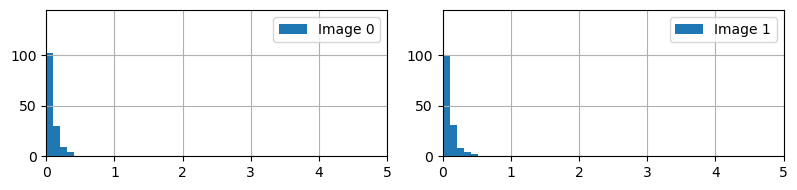

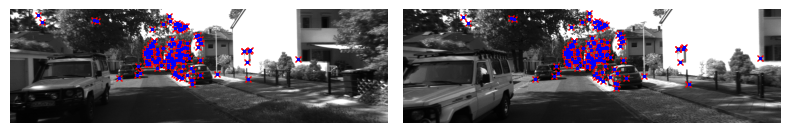

In [8]:
vo.show_reproj_results(views, tracks, cam0_K, cam0_distortion, print_raw_reproj=True, show_reproj_histogram=True)
vo.visualize_predictions(views, tracks, cam0_K, cam0_distortion)

Get post-optimization solution

Run below to keep the initial views and tracks

In [9]:
views_ini = views.copy()
tracks_ini = tracks.copy()

In [10]:
tic = time.time()

views, tracks, initial_values, results  = vo.vo_nonlinear_optimize(views_ini, tracks_ini, cam0_K, max_reprojection_err)

toc = time.time()
nonlinear = toc - tic
print(f"{nonlinear:.2f} [s]")

/Users/andre/mambaforge/envs/ae598-3dv/lib/python3.12/site-packages/symforce/opt/optimizer.py:267: FutureWarning: debug_stats argument is deprecated, use params.debug_stats
  warnings.warn(


[2024-05-09 14:33:55.124] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 6.158e+00/6.047e+00/6.046e+00, rel reduction: 1.82341e-02, gain ratio: 1.00865e+00
[2024-05-09 14:33:55.189] [info] LM<sym::Optimize> [iter    1] lambda: 1.000e-01, error prev/linear/new: 6.046e+00/5.927e+00/5.926e+00, rel reduction: 1.99465e-02, gain ratio: 1.01019e+00
[2024-05-09 14:33:55.250] [info] LM<sym::Optimize> [iter    2] lambda: 1.000e-02, error prev/linear/new: 5.926e+00/5.895e+00/5.894e+00, rel reduction: 5.30232e-03, gain ratio: 1.01498e+00
[2024-05-09 14:33:55.310] [info] LM<sym::Optimize> [iter    3] lambda: 1.000e-03, error prev/linear/new: 5.894e+00/5.859e+00/5.858e+00, rel reduction: 6.04853e-03, gain ratio: 1.00395e+00
[2024-05-09 14:33:55.370] [info] LM<sym::Optimize> [iter    4] lambda: 1.000e-04, error prev/linear/new: 5.858e+00/5.757e+00/5.760e+00, rel reduction: 1.68508e-02, gain ratio: 9.68426e-01
[2024-05-09 14:33:55.433] [info] LM<sym::Optimize> [iter    


REPROJECTION ERRORS
 Image  0 (  144 points) : (mean, std, max, min) = (0.0745, 0.0797, 0.5337, 0.0001)
 Image (raw reprojection)  0 (  144 points) : (mean, std, max, min) = (0.0745, 0.0797, 0.5337, 0.0001)
 Image  1 (  144 points) : (mean, std, max, min) = (0.0699, 0.0719, 0.4287, 0.0001)
 Image (raw reprojection)  1 (  144 points) : (mean, std, max, min) = (0.0699, 0.0719, 0.4287, 0.0001)


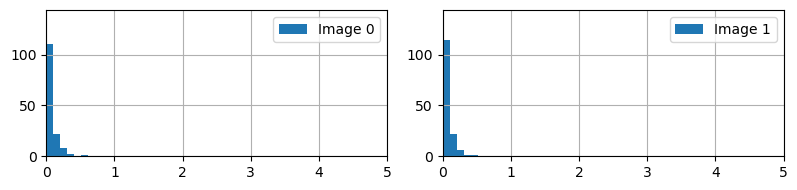

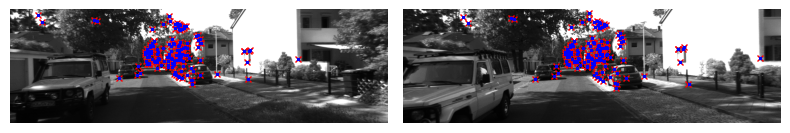

In [11]:
vo.show_reproj_results(views, tracks, cam0_K, cam0_distortion, print_raw_reproj=True, show_reproj_histogram=True)
vo.visualize_predictions(views, tracks, cam0_K, cam0_distortion)

Evaluate change in position between frames

In [12]:
# ground truth
R_inW_ofB0_gt = R_inW_ofB[first_frame_idx].as_matrix()
p_inW_ofB0_gt = p_inW_ofB[first_frame_idx]

R_inW_ofB1_gt = R_inW_ofB[second_frame_idx].as_matrix()
p_inW_ofB1_gt = p_inW_ofB[second_frame_idx]

R_inB0_ofW_gt = R_inW_ofB0_gt.T
p_inB0_ofW_gt = - R_inW_ofB0_gt.T @ p_inW_ofB0_gt

R_inB1_ofW_gt = R_inW_ofB1_gt.T
p_inB1_ofW_gt = - R_inW_ofB1_gt.T @ p_inW_ofB1_gt

R_inC_ofB = T_inC_ofB[:3,:3]
p_inC_ofB = T_inC_ofB[:3,-1]

R_inB_ofC = T_inB_ofC[:3,:3]
p_inB_ofC = T_inB_ofC[:3,-1]

R_inC0_ofW_gt = R_inC_ofB @ R_inB0_ofW_gt
p_inC0_ofW_gt = R_inC_ofB @ p_inB0_ofW_gt + p_inC_ofB

R_inC1_ofW_gt = R_inC_ofB @ R_inB1_ofW_gt
p_inC1_ofW_gt = R_inC_ofB @ p_inB1_ofW_gt + p_inC_ofB

R_inW_ofC0_gt = R_inW_ofB0_gt @ R_inB_ofC
p_inW_ofC0_gt = R_inW_ofB0_gt @ p_inB_ofC + p_inW_ofB0_gt

R_inW_ofC1_gt = R_inW_ofB1_gt @ R_inB_ofC
p_inW_ofC1_gt = R_inW_ofB1_gt @ p_inB_ofC + p_inW_ofB0_gt

# Symforce - Initial values
R_inC0_ofW_ini = results.initial_values['T_inB0_ofA'].R.to_rotation_matrix() @ R_inC0_ofW_gt
p_inC0_ofW_ini = results.initial_values['T_inB0_ofA'].R.to_rotation_matrix() @ p_inC0_ofW_gt + results.initial_values['T_inB0_ofA'].t

R_inC1_ofW_ini = results.initial_values['T_inB1_ofA'].R.to_rotation_matrix() @ R_inC1_ofW_gt
p_inC1_ofW_ini = results.initial_values['T_inB1_ofA'].R.to_rotation_matrix() @ p_inC1_ofW_gt + results.initial_values['T_inB1_ofA'].t

R_inW_ofC0_ini = R_inC0_ofW_ini.T
p_inW_ofC0_ini = - R_inC0_ofW_ini.T @ p_inC0_ofW_ini

R_inW_ofC1_ini = R_inC1_ofW_ini.T
p_inW_ofC1_ini = - R_inC1_ofW_ini.T @ p_inC1_ofW_ini

# Symforce - Optimized values
R_inC0_ofW_sf = results.optimized_values['T_inB0_ofA'].R.to_rotation_matrix() @ R_inC0_ofW_gt
p_inC0_ofW_sf = results.optimized_values['T_inB0_ofA'].R.to_rotation_matrix() @ p_inC0_ofW_gt + results.optimized_values['T_inB0_ofA'].t

R_inC1_ofW_sf = results.optimized_values['T_inB1_ofA'].R.to_rotation_matrix() @ R_inC1_ofW_gt
p_inC1_ofW_sf = results.optimized_values['T_inB1_ofA'].R.to_rotation_matrix() @ p_inC1_ofW_gt + results.optimized_values['T_inB1_ofA'].t

R_inW_ofC0_sf = R_inC0_ofW_sf.T
p_inW_ofC0_sf = - R_inC0_ofW_sf.T @ p_inC0_ofW_sf

R_inW_ofC1_sf = R_inC1_ofW_sf.T
p_inW_ofC1_sf = - R_inC1_ofW_sf.T @ p_inC1_ofW_sf


Error evaluation on optimized results

In [13]:
p_inW_ofC0toC1_ini = p_inW_ofC1_ini - p_inW_ofC0_ini
R_inC1_ofC0_ini = R_inW_ofC1_ini.T @ R_inW_ofC0_ini

p_inW_ofC0toC1_sf = p_inW_ofC1_sf - p_inW_ofC0_sf
R_inC1_ofC0_sf = R_inW_ofC1_sf.T @ R_inW_ofC0_sf

p_inW_ofC0toC1_gt = p_inW_ofC1_gt - p_inW_ofC0_gt
R_inC1_ofC0_gt = R_inW_ofC1_gt.T @ R_inW_ofC0_gt

print(f"Results\n{'='*100}")
dR_err_ini = R.from_matrix(R_inC1_ofC0_ini.T @ R_inC1_ofC0_gt).as_euler('xyz', degrees=True)
dR_err_sf = R.from_matrix(R_inC1_ofC0_sf.T @ R_inC1_ofC0_gt).as_euler('xyz', degrees=True)
print(f'dR: {dR_err_ini} (init.) --> {dR_err_sf} (optm.) [deg] (xyz)')
print('dR scalar: {:.5f} (init.) --> {:.5f} (optm.) [deg]'.format(
    pose_metrics.rotational_error(R_inC1_ofC0_ini, R_inC1_ofC0_gt),
    pose_metrics.rotational_error(R_inC1_ofC0_sf, R_inC1_ofC0_gt),
))

dp_err_ini = p_inW_ofC0toC1_ini - p_inW_ofC0toC1_gt
dp_err_sf = p_inW_ofC0toC1_sf - p_inW_ofC0toC1_gt
print(f'dp: {np.linalg.norm(dp_err_ini):.2f} (init.) --> {np.linalg.norm(dp_err_sf):.2f} (optm.) [m]')


print(f"\nTiming\n{'='*100}")
print(f"Analytical guess: {analyctical_guess:.2f} [s]")
print(f"Non linear (VO): {nonlinear:.2f} [s]")

Results
dR: [ 0.06185007 -7.1091489   0.02821215] (init.) --> [ 0.04725896 -7.1019904   0.03146029] (optm.) [deg] (xyz)
dR scalar: 7.10949 (init.) --> 7.10223 (optm.) [deg]
dp: 3.86 (init.) --> 3.86 (optm.) [m]

Timing
Analytical guess: 5.11 [s]
Non linear (VO): 2.80 [s]


In [14]:
print("Analytical pose difference: {}".format(p_inW_ofC0toC1_ini))
print("Analytical pose difference: {}".format(p_inW_ofC0toC1_sf))
print("Analytical pose difference: {}".format(p_inW_ofC0toC1_gt))

Analytical pose difference: [-3.79140149  0.3598753  -0.09193417]
Analytical pose difference: [-3.79128884  0.35651601 -0.0875573 ]
Analytical pose difference: [ 0.05808596  0.12916169 -0.00392825]


In [15]:
def getAngle(P, Q):
    """
    https://math.stackexchange.com/a/4289045
    """
    R = np.dot(P, Q.T)
    cos_theta = (np.trace(R)-1)/2
    return np.arccos(cos_theta) * (180/np.pi)


# Test that angular error is in degrees
theta = 45
r1 = R.from_euler('zyx', [0, 0, theta], degrees=True).as_matrix()
r2 = R.from_euler('zyx', [0, 0, 0], degrees=True).as_matrix()

np.allclose(theta,
            pose_metrics.rotational_error(r1, r2),
            getAngle(r1, r2))

True